## Dataset: отзывы о приложении (`'Ru'`)

Задание из 2-х частей.
Берем отызывы за лето
1. Учим conv сеть для классификации - выбить auc выше 0.95
2. Предобучаем word2vec и его эмбединга инициализируем сетку, как влияет на качество?

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import datetime
from stop_words import get_stop_words
from string import punctuation
from pymorphy2 import MorphAnalyzer
from nltk.tokenize import word_tokenize
import regex as re
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from nltk.probability import FreqDist
import tensorflow.keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Input, Embedding, Conv1D, GlobalMaxPool1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import TensorBoard 
#from tensorflow.keras.objectives import categorical_crossentropy
from tensorflow.keras.callbacks import EarlyStopping 
from gensim.models import Word2Vec
import multiprocessing

In [4]:
seed = 1234
np.random.seed(seed)
tf.random.set_seed(seed)
max_words = 2000
max_len = 50
# Training
epochs = 20
batch_size = 4096
vec_len = 10

sw = set(get_stop_words("ru"))
exclude = set(punctuation)
morpher = MorphAnalyzer()

rev_df = pd.read_excel('data/отзывы за лето.xls', parse_dates=[2])

TARGET = 'target'
PROCESSED = 'preprocessed'
rev_df

,Rating,Content,Date
0,5,It just works!,2017-08-14
1,4,В целом удобноное приложение...из минусов хотя...,2017-08-14
2,5,Отлично все,2017-08-14
3,5,Стал зависать на 1% работы антивируса. Дальше ...,2017-08-14
4,5,"Очень удобно, работает быстро.",2017-08-14
...,...,...,...
20654,1,"Ну и шляпа,с роот правами бесполезная прога,ра...",2017-06-01
20655,5,Ок,2017-06-01
20656,4,Доволен,2017-06-01
20657,1,"Песопаснасть, рут ни нужын",2017-06-01


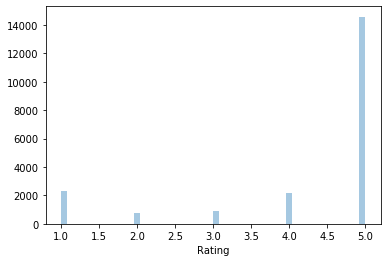

In [10]:
sns.distplot(rev_df['Rating'], label='Rating distribution', kde=False)
plt.show()

In [7]:
def preprocess_text(txt):
       
    txt = str(txt)
    txt = re.sub(r'( )+', " ", re.sub(r'[^\w\s]', " ", txt)).strip()
    txt = "".join(c for c in txt if c not in exclude)
    txt = txt.lower()
    txt = [morpher.parse(word)[0].normal_form for word in txt.split() if word not in sw]
    txt = " ".join(txt)
    txt = re.sub("\sне", "не", txt)
    return txt


def get_splits(data):
    
    #Разделение датасета на 3 сплита
        
    print(f"Preparing splits...", end=" ")
    
    # Split dataset on 3 folds
    train, test = train_test_split(data, test_size=0.6, shuffle=True, random_state=seed)
    valid, test = train_test_split(test, test_size=0.5, shuffle=True, random_state=seed)
    
    return train, valid, test   


def prepare_data(df: pd.DataFrame,
                 n_classes: int,
                 processed_field: str = PROCESSED,
                 target_field: str = TARGET) -> pd.DataFrame:
    
    assert n_classes in [2,5], 'Bad Number of classes'
    
    print(f"Data preparing...", end="")
    
    """
    Предобработка данных под тип классификатора. Преобразование таргета для one-hot encoding
    Ожидает на вход n_classes: 2 | 5
    """
    
    
    df[processed_field] = df['Content'].apply(preprocess_text)
    
    if n_classes == 2:
        df = df[df['Rating'] != 3]
        df[target_field] = (df['Rating'] > 3).astype('uint8')
        
    else:
        df[target_field] = df['Rating'] - 1
    
    return df

In [11]:
def build_train_voc(df_train, processed_field=PROCESSED):
    
    # Train словарь из выбранных токенов
       
    
    train_corpus = " ".join(df_train[processed_field])
   
    tokens = word_tokenize(train_corpus)
    
    tokens_filtered = [word for word in tokens if word.isalnum()]
    dist = FreqDist(tokens_filtered)
    tokens_filtered_top = [pair[0] for pair in dist.most_common(max_words-1)]
    
    print('Top-10 filtered tokens:', tokens_filtered_top[:10])
    
    vocabulary = {v: k for k, v in dict(enumerate(tokens_filtered_top, 1)).items()}
    
    return vocabulary


def text_to_sequence(text, maxlen):
              
    result = []
    tokens = word_tokenize(text.lower())
    tokens_filtered = [word for word in tokens if word.isalnum()]
    for word in tokens_filtered:
        if word in vocabulary:
            result.append(vocabulary[word])
    padding = [0]*(maxlen-len(result))
    return padding + result[-maxlen:]



def plot_history(history):
    
    #Потери и точность модели  
        
    fig, ax = plt.subplots(1,2, figsize=(16,4))

    ax[0].plot(history.history['loss'], label='train loss')
    ax[0].plot(history.history['val_loss'], label='validation loss')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].legend()

    ax[1].plot(history.history['accuracy'], label='train accuracy')
    ax[1].plot(history.history['val_accuracy'], label='validation accuracy')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()

    plt.show()

## Модель для мультиклассовой классификации

In [18]:
num_cl = 5
data = prepare_data(df = rev_df, n_classes = num_cl)
df_train, df_val, df_test = get_splits(data)
vocabulary = build_train_voc(df_train, processed_field=PROCESSED)

x_train = np.asarray([text_to_sequence(text, max_len) for text in df_train["preprocessed"]], dtype=np.int32)
x_test = np.asarray([text_to_sequence(text, max_len) for text in df_test["preprocessed"]], dtype=np.int32)
x_val = np.asarray([text_to_sequence(text, max_len) for text in df_val["preprocessed"]], dtype=np.int32)
print(f'Train.shape: {x_train.shape}, Val.shape:{x_val.shape}, Test.shape: {x_test.shape}')

y_train = tf.keras.utils.to_categorical(df_train[TARGET], num_cl)
y_val = tf.keras.utils.to_categorical(df_val[TARGET], num_cl)
y_test = tf.keras.utils.to_categorical(df_test[TARGET], num_cl)

Data preparing...Preparing splits...Organizing vocabulary:
Top-10 filtered tokens:
['приложение', 'удобно', 'работать', 'удобный', 'отлично', 'нравиться', 'хороший', 'телефон', 'отличный', 'супер']
Train.shape: (8263, 50), Val.shape:(6198, 50), Test.shape: (6198, 50)


In [59]:
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_len))
model.add(Conv1D(128, 3))
model.add(Activation("relu"))
model.add(GlobalMaxPool1D())
model.add(Dense(100))
model.add(Activation("relu"))
model.add(Dropout(0.4))
model.add(Dense(num_cl))
model.add(Activation('tanh'))
model.compile(loss='binary_crossentropy', ptimizer='Adam',metrics=['accuracy'])



In [25]:
history = model.fit(x=x_train,
                    y=y_train,
                    batch_size=batch_size,
                    validation_data=(x_val, y_val),
                    epochs=epochs,
                    verbose=0
                    )

score = model.evaluate(x_test, y_test)

6198/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [22]:
print(f"Multiclass model score: {score[1]}")

Multiclass model score: 0.9141656756401062


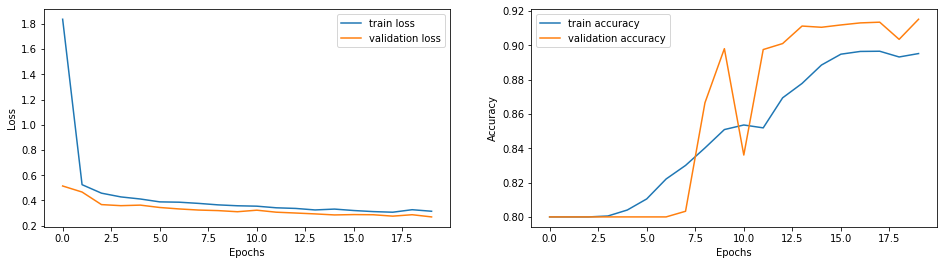

In [23]:
plot_history(history)

## Модель для бинарной классификации

In [33]:
num_cl = 2
data = prepare_data(df=data, n_classes=num_cl)
df_train, df_val, df_test = get_splits(data)
vocabulary = build_train_voc(df_train, processed_field=PROCESSED)

x_train = np.asarray([text_to_sequence(text, max_len) for text in df_train["preprocessed"]], dtype=np.int32)
x_test = np.asarray([text_to_sequence(text, max_len) for text in df_test["preprocessed"]], dtype=np.int32)
x_val = np.asarray([text_to_sequence(text, max_len) for text in df_val["preprocessed"]], dtype=np.int32)
print(f'Train.shape: {x_train.shape}, Val.shape:{x_val.shape}, Test.shape: {x_test.shape}')

y_train = tf.keras.utils.to_categorical(df_train[TARGET], num_cl)
y_val = tf.keras.utils.to_categorical(df_val[TARGET], num_cl)
y_test = tf.keras.utils.to_categorical(df_test[TARGET], num_cl)

Data preparing...

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Preparing splits...Organizing vocabulary:
Top-10 filtered tokens:
['приложение', 'удобно', 'работать', 'удобный', 'отлично', 'нравиться', 'отличный', 'хороший', 'телефон', 'супер']
Train.shape: (7899, 50), Val.shape:(5924, 50), Test.shape: (5925, 50)


In [34]:
model2 = Sequential()
model2.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_len))
model2.add(Conv1D(128, 3))
model2.add(Activation("relu"))
model2.add(GlobalMaxPool1D())
model2.add(Dense(100))
model2.add(Activation("relu"))
model2.add(Dropout(0.3))
model2.add(Dense(num_cl))
model2.add(Activation('tanh'))
 
model2.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [35]:
history = model2.fit(x=x_train,
                    y=y_train,
                    batch_size=batch_size,
                    validation_data=(x_val, y_val),
                    epochs=epochs,
                    verbose=0
                    )

In [36]:
res = model2.predict(x_test)
print(f'Test score: {round(roc_auc_score(y_test, res),3)}')

Test score: 0.938


Почти 0.95
Хоть и ставил вначале фиксированные seed, все равно случайная генерация идет, и пробить 0.95 за счет нее можно пробить. Как зафиксировать?

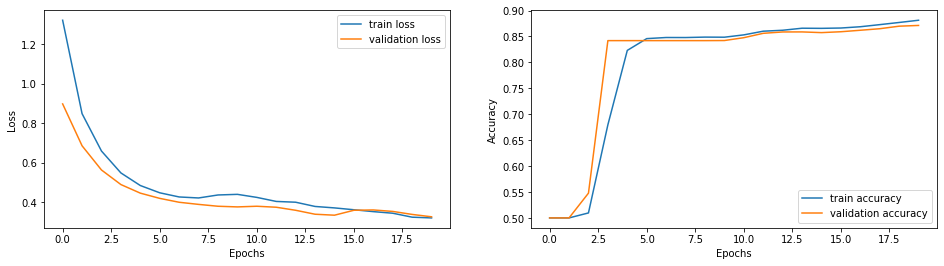

In [37]:
plot_history(history)

### Тестирование на предобученных `Word2Vec` батчах

In [39]:
sentences_lists = [[sentence] for sentence in data[PROCESSED].tolist()]
sentences_lists[:10]

[['it just works'],
 ['целое удобноной приложение минус хотеть большой доступ персональный данные телефон приходиться пользоваться ограниченный режим'],
 ['отлично'],
 ['зависать 1 работа антивирус ранее пользоваться нормально'],
 ['удобно работать быстро'],
 ['удобно норма'],
 ['удобный приложение'],
 ['устраивать'],
 ['работать чётко отличие банкомат вечно зависать тупить'],
 ['']]

In [40]:
modelW2V = Word2Vec(sentences=sentences_lists,
                    size=vec_len,
                    window=10,
                    min_count=2,
                    workers=multiprocessing.cpu_count())

In [41]:
buffer = np.random.random((max_words, vec_len))

In [42]:
for word in vocabulary:
    if word in modelW2V.wv:
        # print(word, modelW2V.wv[word])
        buffer[vocabulary[word]] = modelW2V.wv[word]

In [55]:
model3 = Sequential()
model3.add(Embedding(input_dim=max_words, output_dim=vec_len, weights=[buffer], input_length=max_len))
model3.add(Conv1D(128, 3))
model3.add(Activation("relu"))
model3.add(GlobalMaxPool1D())
model3.add(Dense(100))
model3.add(Activation("relu"))
model3.add(Dropout(0.1))
model3.add(Dense(2))
model3.add(Activation('tanh'))

In [56]:
model3.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [57]:
history = model3.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=75,
                    verbose=0,
                    validation_split=0.2,
                    )

In [58]:
res = model3.predict(x_test)
print(f'Test score: {round(roc_auc_score(y_test, res),3)}')

Test score: 0.556


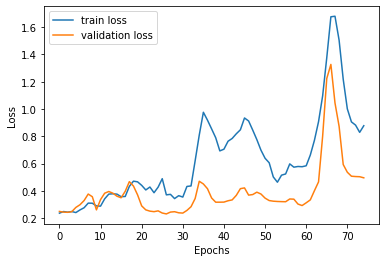

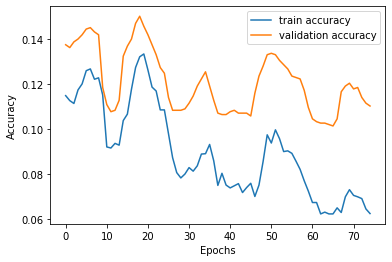

In [54]:
plt.figure()
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.figure()
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()